In [28]:
from os import path
import matplotlib.pyplot as plt

from pyedflib import highlevel
import pyedflib

import numpy as np
import pandas as pd
from jupyterthemes import jtplot

%matplotlib inline

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

In [18]:
from os import path

import numpy as np
import pandas as pd

import pyedflib
import librosa
from librosa.feature import mfcc


def segments_labels(dataset_name):
    ms = 1e-3
    edf_file = f'../data/psg_audio/{dataset_name}.edf'
    csv_file = f'../data/psg_audio/snore_annotations/{dataset_name}.csv'

    snore_annotations = pd.read_csv(csv_file)

    with pyedflib.EdfReader(edf_file) as f:
        n_samples = f.getNSamples()[0]
        header = f.getSignalHeaders()
        sample_rate = header[0]['sample_rate']

        seg_step = 0.25
        seg_duration = 5
        noise_margin = 30.0
        n_steps = int(np.floor(((n_samples / sample_rate - seg_duration) / seg_step)))
        psg_duration = n_steps * seg_step

        xs = np.linspace(0, psg_duration, n_steps, endpoint=False)

        snore_durations = pd.concat([pd.DataFrame([[-seg_duration, 0]], columns=['Start', 'Duration']),
                                     snore_annotations,
                                     pd.DataFrame([[n_samples / sample_rate + seg_duration, 0]],
                                                  columns=['Start', 'Duration'])])

        idx_a = idx_b = 0
        start_a, duration_a = snore_durations.iloc[idx_a]
        end_a = start_a + duration_a
        start_b, duration_b = snore_durations.iloc[idx_b]
        end_b = start_b + duration_b

        segments = []
        labels = []

        for idx, x in enumerate(xs):
            while end_a < x:
                idx_a += 1
                start_a, duration_a = snore_durations.iloc[idx_a]
                end_a = start_a + duration_a

            while start_b < x + seg_duration:
                idx_b += 1
                start_b, duration_b = snore_durations.iloc[idx_b]
                end_b = start_b + duration_b

            # i < idx_a => (end < x) => no overlapps
            # i >= idx_b => (start >= x + seg_duration) => no overlapps
            # only need to check i such that idx_a <= i < idx_b

            max_overlap = 0.0

            if idx_a >= idx_b:
                ls, ld = snore_durations.iloc[idx_a - 1]
                le = ls + ld
                rs, rd = snore_durations.iloc[idx_a]
                re = rs + rd

                dist = min(x - le, rs - x + seg_duration)
                if dist > noise_margin:
                    segments.append((x, x + seg_duration))
                    labels.append(0)
            else:
                for i in range(idx_a, idx_b):
                    s, d = snore_durations.iloc[i]
                    e = s + d
                    if s < x and x + seg_duration < e:
                        max_overlap = seg_duration
                        break
                    elif x < s and e < x + seg_duration:
                        overlap = e - s
                    else:
                        overlap = min(e - x, x + seg_duration - s)

                    if overlap > max_overlap:
                        max_overlap = overlap

                if max_overlap >= 4.0:
                    segments.append((x, x + seg_duration))
                    labels.append(1)

            if idx % 1000 == 0:
                print(f'{idx + 1:5d} / {len(xs):5d}', end='\r')

    return segments, labels

In [21]:
import h5py
from librosa.feature import mfcc


def mfcc_label(hdf5_file, segments, labels):
    ms = 1e-3

    with h5py.File(hdf5_file, mode='r+') as h5_file:
        audio = h5_file['audio']
        sample_rate = audio.attrs['sample_rate']
        
        if 'mfcc' not in h5_file:
            hop_length = int(31.27 * ms * sample_rate)
            n_fft = int(np.ceil(50 * ms * sample_rate / 512) * 512)
            n_mfcc = 32

            # 160 frames with 31.27 ms of hop length is about 5 seconds
            mfcc_ds = h5_file.require_dataset('mfcc', shape=(len(segments), n_mfcc, 160), dtype=np.float32)

            for i, (seg_start, seg_end) in enumerate(segments):
                seg_start_idx = int(seg_start * sample_rate)
                seg_end_idx = int(seg_end * sample_rate)

                # fs.shape = (n_mfcc, # of frames)
                audio_signal = audio[seg_start_idx:seg_end_idx] / (1 << 15)
                fs = mfcc(y=audio_signal, sr=sample_rate,
                          n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
                
                # it converts float64 to float32 automatically
                mfcc_ds[i, ...] = fs[:, :160]

                if i % 100 == 0:
                    print(f'{i + 1:4d} / {len(segments):4d}', end='\r')
        
        label_ds = h5_file.require_dataset('label', shape=(len(segments),), dtype=np.float32)
        label_ds[...] = labels
        
        segment_ds = h5_file.require_dataset('segment', shape=(len(segments), 2), dtype=np.int64)
        segment_ds[...] = np.asarray(segments) * sample_rate

In [41]:
from glob import glob


# for edf_file in glob('../data/psg_audio/*.edf'):
# dataset_name = edf_file.split('/')[-1].split('.')[0]
# dataset_name = '00000995-100507'
# dataset_name = '00001010-100507'
# dataset_name = '00001016-100507'
# dataset_name = '00001041-100507'
# dataset_name = '00001049-100507'
# dataset_name = '00001051-100507'
dataset_name = '00001053-100507'
# dataset_name = '00001057-100507'
# dataset_name = '00001073-100507'
# dataset_name = '00001171-100507'
# dataset_name = '00001178-100507'

segments, labels = segments_labels(dataset_name)

print(dataset_name)
h5_file_name = dataset_name + '.h5'
mfcc_label(h5_file_name, segments, labels)

00001053-100507


In [1]:
from glob import glob
import h5py


for h5_file_name in glob('*.h5'):
    with h5py.File(h5_file_name, mode='r') as h5_file:
        print(h5_file_name, 'mfcc' in h5_file)


00001016-100507.h5 True
00001041-100507.h5 True
00000995-100507.h5 True
00001053-100507.h5 True
00001178-100507.h5 True
00001057-100507.h5 True
00001073-100507.h5 True
00001010-100507.h5 True
00001049-100507.h5 True
00001171-100507.h5 True
00001051-100507.h5 True


In [52]:
import torch
import torch.nn as nn
from torch.nn import functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SnoreModel(nn.Module):
    def __init__(self):
        super().__init__()

        # modified Kahn (2019) architecture
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do1 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do2 = nn.Dropout2d(0.25)

        # fully connected
        self.d1 = nn.Linear(14592, 512)
        self.do3 = nn.Dropout(0.5)
        self.d2 = nn.Linear(512, 64)
        self.d3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.do1(self.maxpool1(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.do2(self.maxpool2(x))
        x = F.relu(self.d1(x.view(x.size(0), -1)))
        x = F.relu(self.d2(self.do3(x)))
        x = torch.sigmoid(self.d3(x))

        return x

In [53]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose

import torch.optim

from sklearn.model_selection import train_test_split


class SnoreDataset(Dataset):
    def __init__(self, mfcc_ds, label_ds):
        self.x = mfcc_ds
        self.y = label_ds
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, ix):
        return self.x[ix][None], self.y[ix][None]


def get_model():
    model = SnoreModel().to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    return model, loss_fn, optimizer


# def get_data(file_name):
#     with h5py.File(file_name, mode='r') as h5_file:
#         x = h5_file['mfcc'][...]
#         y = h5_file['label'][...]

# #     train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.1)
    
#     n_samples = x.shape[0]
#     n_trains = int(n_samples * 0.8)
#     train_x = x[:n_trains]
#     valid_x = x[n_trains:]
#     train_y = y[:n_trains]
#     valid_y = y[n_trains:]
    
#     train_dl = DataLoader(SnoreDataset(train_x, train_y), batch_size=16, shuffle=True)
#     valid_dl = DataLoader(SnoreDataset(valid_x, valid_y), batch_size=16, shuffle=True)
    
#     return train_dl, valid_dl


@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x.to(device))
    is_correct = (prediction > 0.5) == y.to(device)
    
    return is_correct.cpu().numpy().squeeze()

In [54]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    batch_x, batch_y = inputs
    
    x = batch_x.to(device)
    y = batch_y.to(device)

    pred_y = model(x)
    optimizer.zero_grad()
    loss = criterion(pred_y, y)
    loss.backward()
    optimizer.step()
    
    return loss.item()


@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    batch_x, batch_y = inputs
    
    x = batch_x.to(device)
    y = batch_y.to(device)
    
    pred_y = model(x)
    loss = criterion(pred_y, y)
    
    return loss.item()

In [24]:
from glob import glob


# h5_files = [h5py.File(f_name) for f_name in sorted(glob('*.h5'))]

In [55]:
h5_files

[<HDF5 file "00000995-100507.h5" (mode r)>,
 <HDF5 file "00001010-100507.h5" (mode r)>,
 <HDF5 file "00001016-100507.h5" (mode r)>,
 <HDF5 file "00001041-100507.h5" (mode r)>,
 <HDF5 file "00001049-100507.h5" (mode r)>,
 <HDF5 file "00001051-100507.h5" (mode r)>,
 <HDF5 file "00001053-100507.h5" (mode r)>,
 <HDF5 file "00001057-100507.h5" (mode r)>,
 <HDF5 file "00001073-100507.h5" (mode r)>,
 <HDF5 file "00001171-100507.h5" (mode r)>,
 <HDF5 file "00001178-100507.h5" (mode r)>]

In [56]:
@torch.no_grad()
def cm(model, dls):
    model.eval()
    
    preds = []
    true_y = []

    for i, dl in enumerate(dls):
        for j, (batch_x, batch_y) in enumerate(dl):
            score = model(batch_x.to(device))
            pred = torch.where(score > 0.5, 1., 0.)
            preds.extend(pred.cpu().numpy().tolist())
            true_y.extend(batch_y.tolist())
            print(f'cm {i + 1:3d} / {len(dls):3d}, {j + 1:4d} / {len(dl):4d}', end='\r')
    return confusion_matrix(true_y, preds)

### 11 fold cross validations
- 11 psg audio signals
- 5 epochs for each fold

In [35]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


fold_perf = []

kfold = KFold(n_splits=11)

epochs = 5

for trn_idx, val_idx in kfold.split(range(11)):
    # new model for each fold
    model, loss_fn, optimizer = get_model()
    
    trn_h5 = [h5_files[idx] for idx in trn_idx]
    val_h5 = [h5_files[idx] for idx in val_idx]
    
    trn_dls = [DataLoader(SnoreDataset(f['mfcc'], f['label']), batch_size=64, shuffle=True)
               for f in trn_h5]
    val_dls = [DataLoader(SnoreDataset(f['mfcc'], f['label']), batch_size=64, shuffle=True)
               for f in val_h5]

    perf = [[], []]
    
    for epoch in range(epochs):
        # train over all trn DataLoader
        for i, dl in enumerate(trn_dls):
            for j, (batch_x, batch_y) in enumerate(dl):
                train_batch((batch_x, batch_y), model, loss_fn, optimizer)
                print(f'epoch {epoch:2d} train {i + 1:3d} / {len(trn_dls):3d}, {j + 1:4d} / {len(dl):4d}', end='\r')

        # trn and val confusion matrix
        perf[0].append(cm(model, trn_dls))
        perf[1].append(cm(model, val_dls))
    
    fold_perf.append(perf)


In [43]:
import pickle

with open('11-fold-validation-psg-audio', 'wb') as f:
    pickle.dump(fold_perf, f)

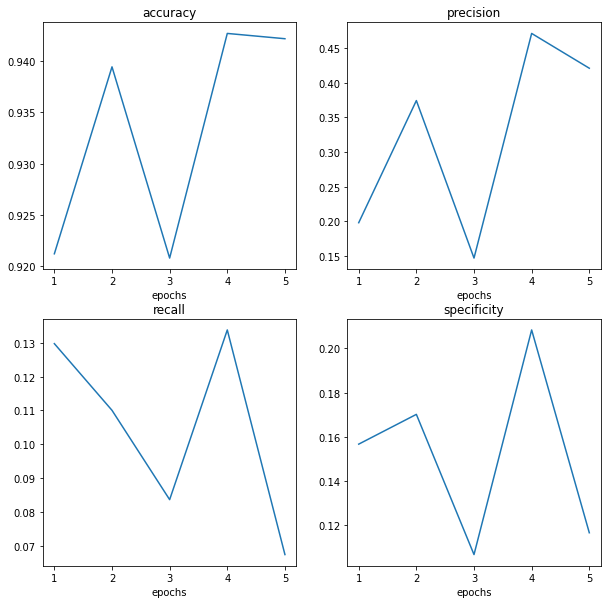

In [105]:
import pickle
import numpy as np

def accuracy_precision_recall_specificity(c_m):
    acc = np.trace(c_m) / np.sum(c_m)
    recall = c_m[1, 1] / np.sum(c_m[1]) if np.sum(c_m[1]) != 0 else 0
    precision = c_m[1, 1] / np.sum(c_m[:, 1]) if np.sum(c_m[:, 1]) != 0 else 0
    spec = c_m[0, 0] / np.sum(c_m[:, 0])

    return acc, precision, recall, spec

scores = []

with open('11-fold-validation-psg-audio', 'rb') as f:
    cms = pickle.load(f)
    
    for epoch in range(5):
        conf_mat = sum([cms[fold][1][epoch] for fold in range(11)])
        scores.append(accuracy_precision_recall_f1(conf_mat))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

epochs = range(1, 6)
titles = ['accuracy', 'precision', 'recall', 'specificity']

ax[0, 0].plot(epochs, [s[0] for s in scores])
ax[0, 1].plot(epochs, [s[1] for s in scores])
ax[1, 0].plot(epochs, [s[2] for s in scores])
ax[1, 1].plot(epochs, [s[3] for s in scores])

for a, t in zip(ax.flatten(), titles):
    a.set_title(t)
    a.set_xlabel('epochs')


[[529923  17215]
 [ 28463   4241]]
accuracy: 0.9212233677450063
recall 0.12967832681017613
precision 0.19766032811334824
f1_score: 0.15661004431314623


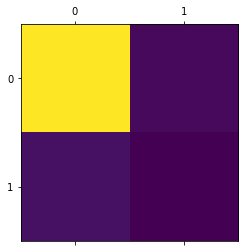

In [36]:
import matplotlib.pyplot as plt

c_m = np.sum(np.asarray(([l[1][0] for l in fold_perf])), axis=0)
print(c_m)
print('accuracy:', np.trace(c_m) / np.sum(c_m))
recall = c_m[1, 1] / np.sum(c_m[1])
print('recall', recall)
precision = c_m[1, 1] / np.sum(c_m[:, 1])
print('precision', precision)
f1_score = 2 / (1 / recall + 1 / precision)
print('f1_score:', f1_score)

fig, ax = plt.subplots()

ax.matshow(c_m)

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix


model, loss_fn, optimizer = get_model()


trn_idx = range(10)
val_idx = [10]

trn_h5 = [h5_files[idx] for idx in trn_idx]
val_h5 = [h5_files[idx] for idx in val_idx]

trn_dls = [DataLoader(SnoreDataset(f['mfcc'], f['label']), batch_size=64, shuffle=True)
           for f in trn_h5]
val_dls = [DataLoader(SnoreDataset(f['mfcc'], f['label']), batch_size=64, shuffle=True)
           for f in val_h5]
    
model.eval()
with torch.no_grad():
    preds = []
    true_y = []

    for i, dl in enumerate(val_dls):
        for j, (batch_x, batch_y) in enumerate(dl):
            score = model(batch_x.to(device))
            pred = torch.where(score > 0.5, 1., 0.)
            preds.extend(pred.cpu().numpy().tolist())
            true_y.extend(batch_y.tolist())
            print(f'val acc {i + 1:3d} / {len(val_dls):3d}, {j + 1:4d} / {len(dl):4d}', end='\r')
    cm = confusion_matrix(true_y, preds)
    print('val cm:', cm)


val cm: [[    0 99270]2 / 1552
 [    0     9]]


Text(0, 0.5, 'snore counts')

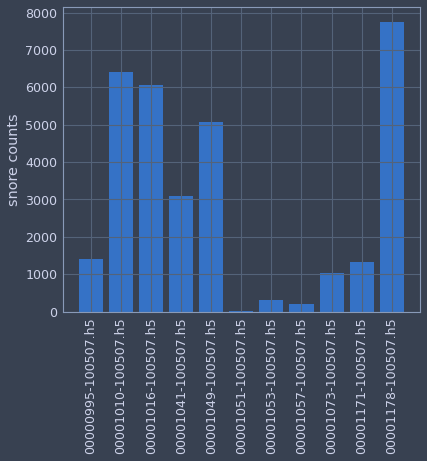

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.bar(range(len(h5_files)), [np.sum(h5['label']) for h5 in h5_files])

ax.set_xticks(range(len(h5_files)))
ax.set_xticklabels([h5.filename for h5 in h5_files])
for l in ax.get_xticklabels():
    l.set_rotation(90)

ax.set_ylabel("snore counts")

### Testing `WeightedRandomSampler`
- `weights` doesn't need to be normalized (summed to be 1)
- `num_samples` specifies the total number of samples from a DataLoader
    - I might want it be the twice of snore noises

In [21]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


x = np.arange(8)
y = np.arange(8)

test_ds = SnoreDataset(x, y)
weights = np.ones_like(x, dtype=np.float32)
weights[:6] = weights[:6] / 100
print(weights)

dl = DataLoader(test_ds, batch_size=4, sampler=WeightedRandomSampler(weights, num_samples=6))

for batch_x, batch_y in dl:
    print(batch_x, batch_y)

[0.01 0.01 0.01 0.01 0.01 0.01 1.   1.  ]
tensor([[7],
        [7],
        [6],
        [7]]) tensor([[7],
        [7],
        [6],
        [7]])
tensor([[7],
        [7]]) tensor([[7],
        [7]])


In [50]:
labels = h5_files[0]['label'][...]
ratio_snore = np.mean(labels)
weights = np.ones_like(labels, dtype=np.float32)
weights[labels == 0] = weights[labels == 0] * ratio_snore / (1 - ratio_snore)
print(np.sum(weights), labels.shape)

1411.0
2821.9995 (66047,)


### 11 fold cross validation using `WeightedRandomSampler`
- `num_samples` is twice of the number of snore noises
- I used `replacement=True`. Does it make a difference?

In [67]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


def DataLoader_with_WeightedRandomSampler(h5):
    ds = SnoreDataset(h5['mfcc'], h5['label'])
    labels = h5['label'][...]
    ratio_snore = np.mean(labels)
    weights = np.ones_like(labels, dtype=np.float32)
    weights[labels == 0] = weights[labels == 0] * ratio_snore / (1 - ratio_snore)
    
    # with replacement=True might, we're likely to use a smaller subset of snore noises
    wrs = WeightedRandomSampler(weights, num_samples=int(np.sum(labels) * 2), replacement=False)
    dl = DataLoader(ds, batch_size=64, sampler=wrs)
    
    return dl


fold_perf = []

kfold = KFold(n_splits=11)

 # number of epochs for each fold
epochs = 5

for fi, (trn_idx, val_idx) in enumerate(kfold.split(range(11))):
    # new model for each fold
    model, loss_fn, optimizer = get_model()
    
    trn_h5 = [h5_files[idx] for idx in trn_idx]
    val_h5 = [h5_files[idx] for idx in val_idx]
    
    trn_dls = [DataLoader_with_WeightedRandomSampler(f) for f in trn_h5]
    val_dls = [DataLoader(SnoreDataset(f['mfcc'], f['label']), batch_size=64)
               for f in val_h5]

    perf = [[], []]
    
    for epoch in range(epochs):
        # train over all trn DataLoader
        for i, dl in enumerate(trn_dls):
            for j, (batch_x, batch_y) in enumerate(dl):
                train_batch((batch_x, batch_y), model, loss_fn, optimizer)
                print(f'fold {fi + 1:2d} / 11, epoch {epoch + 1:2d}, train {i + 1:3d} / {len(trn_dls):3d}, {j + 1:4d} / {len(dl):4d}', end='\r')

        # trn confusion matrix
        perf[0].append(cm(model, trn_dls))

        # val confusion matrix
        perf[1].append(cm(model, val_dls))
    
    fold_perf.append(perf)


In [102]:
with open('11-fold-validation-psg-audio-wrs-no-replacement', 'rb') as f:
    cms = pickle.load(f)

#### validation scores

In [103]:
scores = []

# cms = fold_perf

for epoch in range(5):
    conf_mat = sum([cms[fold][1][epoch] for fold in range(11)])
    scores.append(accuracy_precision_recall_specificity(conf_mat))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

epochs = range(1, 6)
titles = ['accuracy', 'precision', 'recall', 'specificity']

ax[0, 0].plot(epochs, [s[0] for s in scores])
ax[0, 1].plot(epochs, [s[1] for s in scores])
ax[1, 0].plot(epochs, [s[2] for s in scores])
ax[1, 1].plot(epochs, [s[3] for s in scores])

for a, t in zip(ax.flatten(), titles):
    a.set_title(t)
    a.set_xlabel('epochs')

In [89]:
import pickle

with open('11-fold-validation-psg-audio-wrs-no-replacement', 'wb') as f:
    pickle.dump(fold_perf, f)

In [107]:
[s[1] for s in scores]

[0.19766032811334824,
 0.3743888484344117,
 0.14652543732948162,
 0.4715333189562217,
 0.4211930627024967]